In [2]:
%pylab inline
from scipy import optimize
from IPython.display import display, Math, Latex
import emcee
#import corner
from scipy import stats 

Populating the interactive namespace from numpy and matplotlib


In [44]:
#mass units
M = (10.0**10)/0.7
#vol of illustris run
vol = (75.0/(0.7))**3
print(75./0.7)

# Gives the x,y of the histogram for logmasses from the given array of mass
def histog( mf, nbins ):
    hist, bin_edges = np.histogram(mf, bins = nbins)
    # Obtains the center point for each bin
    xcenter = (bin_edges[:-1] + bin_edges[1:])/2
    return np.array(xcenter), np.array(hist/vol)

# Truncates float to n decimal parts
def truncate(d,n):
    before_dec, after_dec = str(d).split('.')
    d = float('.'.join((before_dec, after_dec[0:n-1])))
    return d

# Schechter function
def Schechter(m,phi_s,alpha,m_s):
    MHI = 10.**m
    M_s = 10.**m_s
    return np.log(10.)*phi_s*((MHI/M_s)**(alpha+1))*numpy.exp(-MHI/M_s)

# loads the file with halo masses and makes the quartiles
# file formated env,mass
# j defines if we treat gass or dm j = 0,1
# j = 0 -> gas
# j = 1 -> dm
# j = 2 -> stars and dust
# j = 3 -> black holes
# j = 4 -> central black hole
# minMass minimum mass allowed to have into account a halo
def loadHaloes(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j])> minMass)]
    mass = M*mtable[j][where(M*mtable[j]> minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1
    global q2
    global q3
    global q4
    global q5
    q5 = M*mtable[j][where(M*mtable[j]> minMass)]

    
    q = np.percentile(lsigma,25)
    # Keeps first quartile
    q1 = mass[where(lsigma <= q)]
    # Removes fist quartile from lsigma
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Second quartile
    q = np.percentile(lsigma,33.333333)
    q2 = mass[where(lsigma <= q)]
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Third and Fourth quartile
    q = np.percentile(lsigma,50)
    q3 = mass[where(lsigma <= q)]
    q4 = mass[where(lsigma >= q)]
    
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))

# Loads the file with environment classification T-Web
# file formated env,massgas,masdm
# j defines if we treat gass or dm j = 0,1
# minMass minimum mass allowed to have into account a halo
def loadTweb(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j]) > minMass)]
    mass = M*mtable[j][where(M*mtable[j] > minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1 
    global q2 
    global q3 
    global q4 
    global q5 
    q1 = mass[np.where(lsigma == 3)]
    q2 = mass[np.where(lsigma == 2)]
    q3 = mass[np.where(lsigma == 1)]
    q4 = mass[np.where(lsigma == 0)]
    q5 = mass
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))
    
def SchtrGraph2(bins,filename,title, boolean):
    # Graphics of the mass function for each quartile
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,7) )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
  
    # Callable lists
    qs = [q1,q2,q3,q4]
    indx = ['1st quartile','2nd quartile','3rd quartile','4th quartile']
    cs = ['b','g','r','y']
    fmts = ['o','>','<','s']
    alph = []
    dalph = []
    ms = []
    dms = []
    minx = 40
    maxx = -1
    miny = 100
    maxy = -100
    # Chooses normalization factor as first phi_s
    tmp = histog(log10(q1),15)
    #rint(tmp)
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    phi = 1
    if ( boolean ):
        fiiit,sampler = fitMCMC(tmp)
        #print(fiiit)
        ft = fiiit.T[0]
        errors = fiiit.T[1:]
        phi = ft[0]
    for q,i,co,fm in zip(qs,indx,cs,fmts):
        # Histo for first quartile
        tmp = histog(log10(q),bins)
        tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
        #print tmp
        if ( boolean ):
            logm = linspace(min(tmp[0])-0.3,max(tmp[0])+0.1, 200)
            fiiit,sampler = fitMCMC(tmp)
            #print(fiiit)
            ft = fiiit.T[0]
            errors = fiiit.T[1:].T
            print("......................................................")
            print(ft[0],errors[0])
            print(ft[1],errors[1])
            print(ft[2],errors[2])
            ax.errorbar( tmp[0], log10(tmp[1]*(phi/ft[0])),  1./(sqrt(tmp[1]*vol)), fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        else: 
            ax.errorbar( tmp[0], log10(tmp[1]),  1./(sqrt(tmp[1]*vol)), fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        # Decimals to show
        if ( boolean ):
            m = 5
            ax.plot(logm, log10(Schechter(logm,ft[0],ft[1],ft[2])*(phi/ft[0])),co, 
                 label = r"$\alpha$ = " + str(truncate(ft[1],m))+"\n"
                 + r"$m_\ast$ = " + str(truncate(ft[2],m))+"\n"  )
            alph.append(ft[1])
            dalph.append(errors[1])
            ms.append(ft[2])
            dms.append(errors[2])
            #ax.bar( tmp[0] , log10(tmp[1]), width = tmp[0][1]-tmp[0][2], alpha = 0.4, align = 'center' )
            ax.legend(prop={'size':13})
        #savetxt(name + "q2.csv",(array([tmp[0], tmp[1], sqrt(vol*tmp[1])/(vol*tmp[1])]).T), delimiter = ',')
        #ax.set_title(i, fontsize = 18)
        ax.set_ylabel('$Log_{10}(n)$', fontsize = 20)
        ax.set_xlabel('$Log_{10}(M/M_{\odot})$', fontsize = 20)
        minx = min([minx,min(tmp[0])])
        maxx = max([maxx,max(tmp[0])])
        if ( boolean ):
            miny = min([miny,min(log10(tmp[1]*(phi/ft[0])))])
            maxy = max([maxy,max(log10(tmp[1]*(phi/ft[0])))])
        else:
            miny = min([miny,min(log10(tmp[1]))])
            maxy = max([maxy,max(log10(tmp[1]))])
    ax.set_title(title,fontsize = 20)
    tmp = histog(log10(q5),bins)
    ax.set_xlim(minx-0.3,maxx+0.3)
    if ( boolean ):
        ax.set_xlim(minx-0.3,maxx+1.5)
    ax.set_ylim(miny-0.3,maxy+0.3)
    #ax.set_ylim(-6.,0.)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    savefig(filename)
    return array(alph),array(dalph).T,array(ms),array(dms).T

    
def graph(x,dx,d,name,title,filename):
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,7) )
    q = [1,2,3,4]
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    ax.errorbar( q, x, yerr = dx, fmt='o', ecolor = 'r', c = 'b', markersize=7,elinewidth=1.5)
    ax.set_xlim(0.5,4.5)
    ax.set_ylim(min(x)-d,max(x)+d)
    ax.set_ylabel(name, fontsize = 30)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlabel(r'$Environment$', fontsize = 30)
    ax.set_title(title, fontsize = 30)
    savefig(filename)


107.14285714285715


In [42]:
# Defines functions for emcee
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    norm,alpha,m = p
    # We're using only uniform priors, and only eps has a lower bound
    if norm > 0 and   8 < m < 20 and -3 < alpha < 1:
        return 0
    return -np.inf

# Defines the likelihood
def lnlike(p, x, y, yerr):
    model = SchechterMC(x,p)
    # the likelihood is sum of the lot of normal distributions
    denom = power(yerr,2.)
    lp = -0.5*sum(power((y - model),2.)/denom + log(denom)) 
    return lp

# The probability
def lnprob(p, x, y, yerr):
    lp = lnprior(p)
    if not isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y, yerr)

# MCMC fit
p0 = [0.003, -1., 10.]
def fitSci(tmp,yerr,p):
    return optimize.curve_fit(Schechter,tmp[0] ,tmp[1],p0=[0,-2.0,12], sigma = np.sqrt(tmp[1]/vol),
    #bounds = (np.array([0,-np.inf,8.]),np.array([np.inf,np.inf,20.])),method = 'trf',
    maxfev = 100000)


# Schechter function
def SchechterMC(m,params):
    MHI = 10.**m
    M_s = 10.**params[2]
    return np.log(10.)*params[0]*((MHI/M_s)**(params[1]+1))*numpy.exp(-MHI/M_s)

# Gets the error taking into account the confidence interval
# Arr -> the array
# center -> central value to calculate the interval
# perc -> percent of data within the interval
def getErr(arr, center, perc):
    #conf_int  = stats.norm.interval(perc, loc = center, scale = 1 )
    conf_int  = stats.norm.interval(perc, loc = center, scale = np.std(arr))
    return conf_int

# Uses MCMC emcee to improve the SchechterMC fit and error estimation
# return the best fit values and their respective errors within confidence interval given by perc = (0.68,0.95)
# temp -> data to fit
# Nsteps -> steps for MCMC
# Nwalkers -> number of MCMC walkers
# suggestion: fitMCMC(temp,0.68,1000,50)
def fitMCMC(tmp):
    Nsteps = 1000
    Nwalker = 50
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    # The error in y assuming poisson dist
    yerr = sqrt(tmp[1]/vol)
    # Uses scipy fit as initial guess
    p00 = [0.003,-1.,10.]
    ft,errors = fitSci(tmp,yerr,p00)
    #print ft
    # Creates walkers around initial guess
    Ndim = 3
    walkers = [ft+[1.e-7*random.randn(),1.e-4*random.randn(),1.e-3*random.randn()] for i in range(Nwalker)]
    # Initialises sampler
    sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,args=(tmp[0],tmp[1],yerr))
    pos,prob,state = sampler.run_mcmc(walkers, 500)
    sampler.reset()
    #res=plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
    #axhline(ft[1], color='blue')
    # Runs the walks
    pos,prob,state = sampler.run_mcmc(pos, Nsteps)
    # fit and Errors in format (fit,upper,lower)
    samples = sampler.chain[:, 50:, :].reshape((-1, Ndim))
    #corner.corner(samples, labels=['normV','alpha','m*'], 
     #           truths=[ft[0], ft[1], ft[2]])
    #print shape(samples)
    fit = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    return array(list(fit)),samples

# GAS NEAREST NEIGHBOR

......................................................
0.001951571748 [  3.74149245e-05   3.74336916e-05]
-1.04851076725 [ 0.006      0.0060312]
10.6292768503 [ 0.00784198  0.00812199]
......................................................
0.0035619595843 [  6.28910962e-05   6.31059736e-05]
-0.910212966313 [ 0.00761659  0.00767096]
10.2571773657 [ 0.00719583  0.00736973]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:157: RuntimeWarning: divide by zero encountered in log10


......................................................
0.0022433292134 [  3.65547096e-05   3.60937967e-05]
-0.818800783015 [ 0.00836635  0.00803863]
10.114374814 [ 0.00639809  0.00679489]
......................................................
0.00233102151745 [  3.81977950e-05   3.94343170e-05]
-0.801247532486 [ 0.00909961  0.00931773]
10.0038905728 [ 0.00691969  0.00702232]


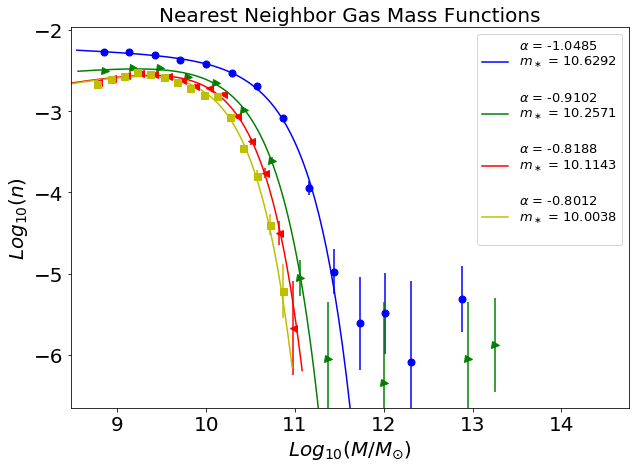

In [45]:
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,0,10**(8.7))
#histo(15)
a = SchtrGraph2(15,"quartilesGas","Nearest Neighbor Gas Mass Functions",True)

In [47]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.00784198  0.00812199]
 [ 0.00719583  0.00736973]
 [ 0.00639809  0.00679489]
 [ 0.00691969  0.00702232]]


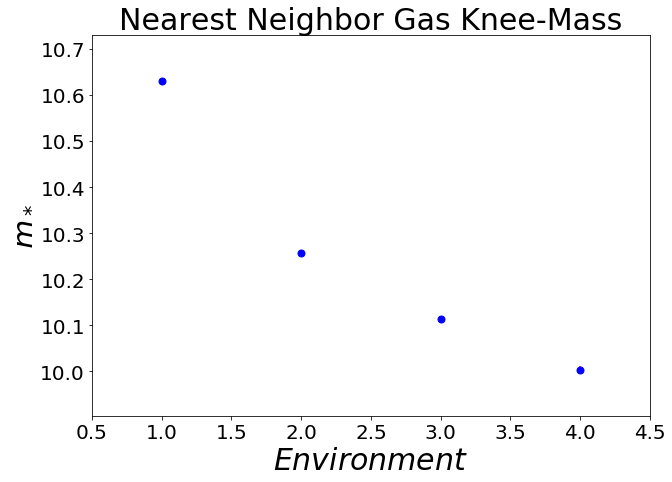

In [48]:
graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor Gas Knee-Mass","Quartiles_knee_mass_gas")

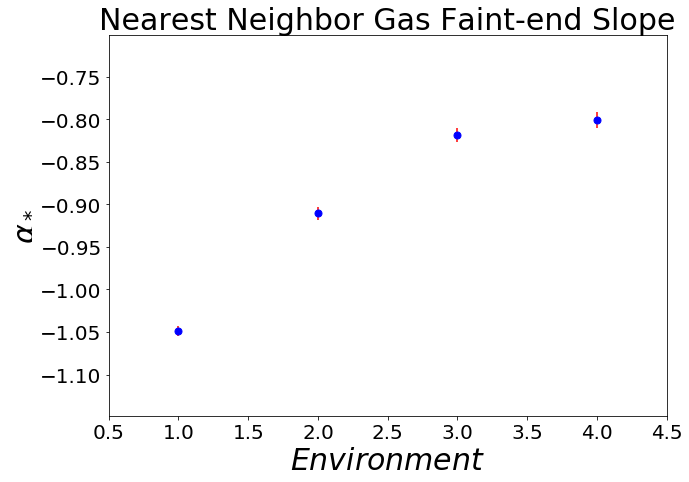

In [49]:
graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor Gas Faint-end Slope","quartiles_slope_gas")

# GAS TWEB

number of haloes before: 191443
number of haloes after: 136584
15975 67762 46331 6516 136584
......................................................
0.00115743975854 [  4.43935446e-05   4.31184598e-05]
-1.04205046456 [ 0.01325309  0.01304549]
10.4164587121 [ 0.01662106  0.01605162]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:157: RuntimeWarning: divide by zero encountered in log10


......................................................
0.00295528518374 [  4.73912445e-05   4.37097781e-05]
-1.00714110748 [ 0.0058212   0.00545705]
10.4047878723 [ 0.00642176  0.00669121]
......................................................
0.00254358463877 [  4.34019735e-05   4.15804629e-05]
-0.902263183653 [ 0.0079735   0.00780602]
10.1796830053 [ 0.00694972  0.00716319]
......................................................
0.000427479370178 [  1.60887467e-05   1.59320778e-05]
-0.763614645646 [ 0.02498198  0.02490507]
9.89660967621 [ 0.01511753  0.01523485]


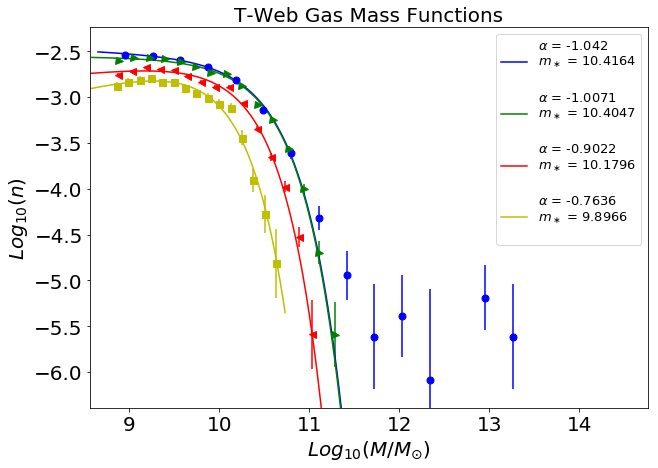

In [50]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,0,10**(8.8))
a = SchtrGraph2(15,"T-Web_Gas","T-Web Gas Mass Functions",True)

In [52]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.01662106  0.01605162]
 [ 0.00642176  0.00669121]
 [ 0.00694972  0.00716319]
 [ 0.01511753  0.01523485]]


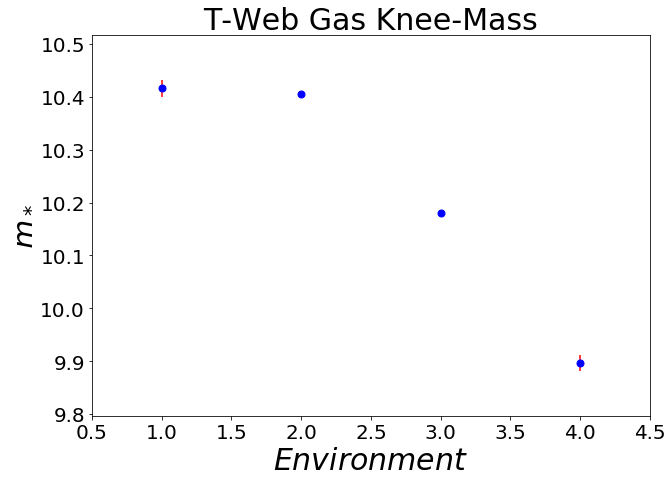

In [53]:
graph(ms,dms,0.1,r"$m_*$","T-Web Gas Knee-Mass","Tweb_knee_mass_Gas")

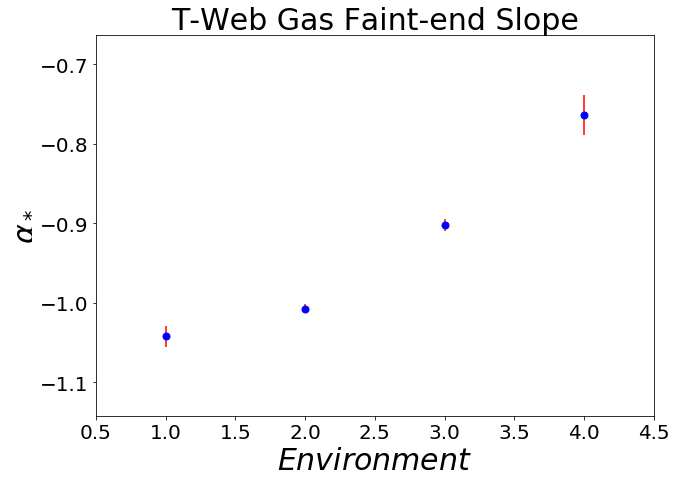

In [54]:
graph(alph,dalph,0.1,r"$\alpha_*$","T-Web Gas Faint-end Slope","TWeb_slope_gas")

# DM NEAREST NEIGHBOR

number of haloes before: 191443
number of haloes after: 115994
28999 28998 28999 28999 115995
......................................................
4.52839960113e-05 [  4.44510358e-06   3.97954269e-06]
-1.58425624757 [ 0.00539836  0.00510691]
13.3221345184 [ 0.04932265  0.05180241]
......................................................
0.000205083702986 [  2.01164602e-05   1.93317076e-05]
-1.71418475061 [ 0.01010421  0.01003892]
12.0062614038 [ 0.03752087  0.03553419]
......................................................
0.000317885479819 [  2.43482059e-05   2.31791235e-05]
-1.68311320786 [ 0.01286837  0.01261984]
11.5323697315 [ 0.02493882  0.02402284]
......................................................
0.000281288184719 [  2.57527274e-05   2.35254971e-05]
-1.80623827655 [ 0.01510403  0.01491227]
11.3586018811 [ 0.02565923  0.02561771]


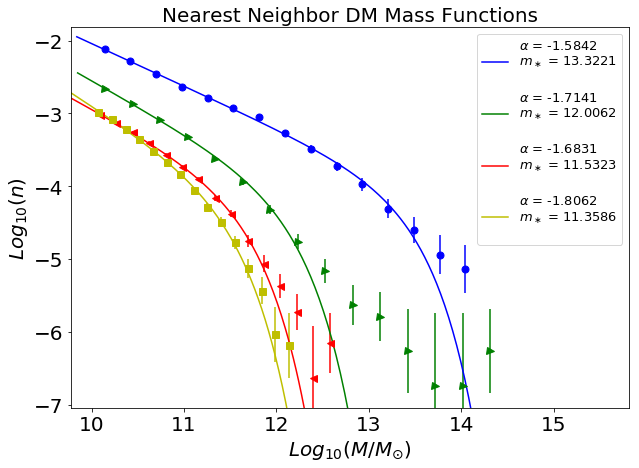

In [55]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,1,10**(10))
#histo(15)
a = SchtrGraph2(15,"quartilesDM","Nearest Neighbor DM Mass Functions",True)

In [56]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.04932265  0.05180241]
 [ 0.03752087  0.03553419]
 [ 0.02493882  0.02402284]
 [ 0.02565923  0.02561771]]


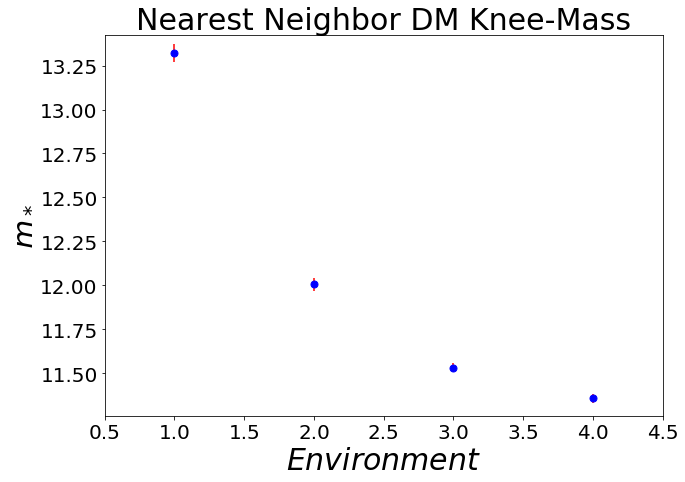

In [57]:
graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor DM Knee-Mass","Quartiles_knee_mass_DM")

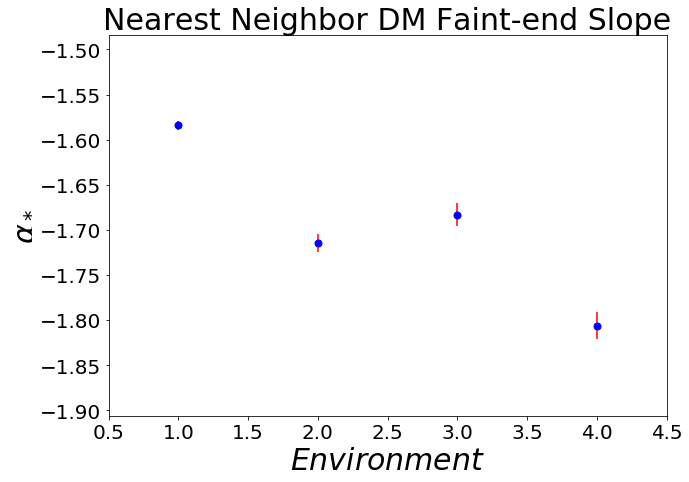

In [58]:
graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor DM Faint-end Slope","quartiles_slope_DM")

# DM TWEB ( Schechter functions are well adjusted to MF )

number of haloes before: 191443
number of haloes after: 115994
15867 56579 37920 5628 115994


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
3.68023481949e-09 [  2.78192828e-09   1.73434821e-08]
-1.7202985668 [ 0.00621213  0.00516228]
18.1499276875 [ 0.18828     0.33750226]
......................................................
7.67951287594e-05 [  5.69409688e-06   5.08446612e-06]
-1.75286901239 [ 0.00459042  0.00462282]
12.7088948996 [ 0.02933425  0.03077103]
......................................................
0.000206846828637 [  1.41613033e-05   1.35853056e-05]
-1.76013838352 [ 0.00934853  0.00958598]
11.7095307442 [ 0.0221105   0.02144581]
......................................................
0.000108255094039 [  2.03335331e-05   1.74612996e-05]
-1.6803439759 [ 0.04810056  0.04537874]
11.0098479238 [ 0.04791857  0.04746007]


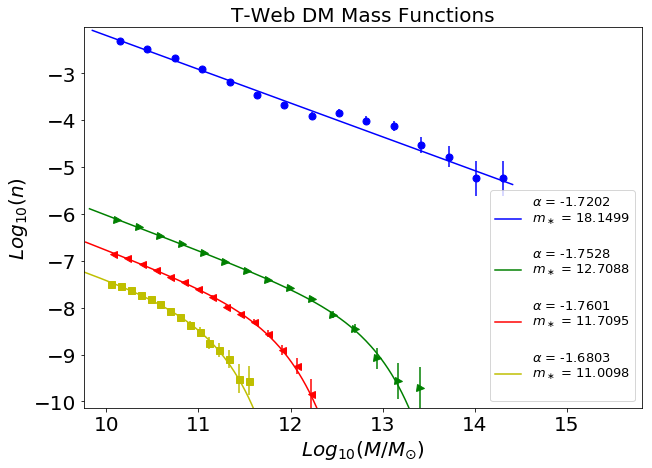

In [59]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,1,10**(10))
a = SchtrGraph2(15,"T-Web_DM","T-Web DM Mass Functions",True)

In [60]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.18828     0.33750226]
 [ 0.02933425  0.03077103]
 [ 0.0221105   0.02144581]
 [ 0.04791857  0.04746007]]


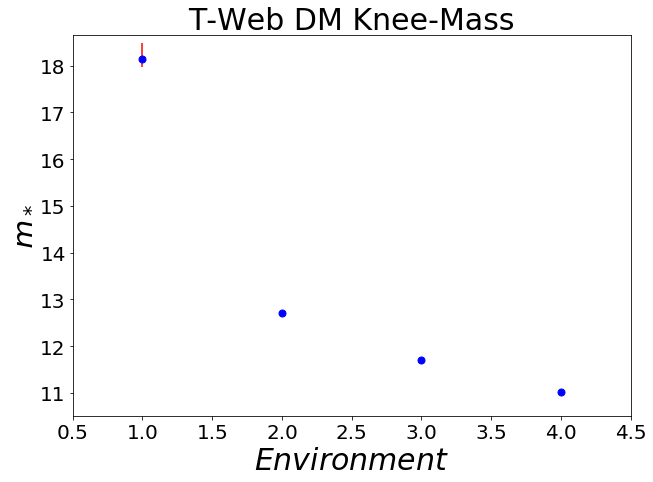

In [61]:
graph(ms,dms,0.5,r"$m_*$","T-Web DM Knee-Mass","Tweb_knee_mass_DM")

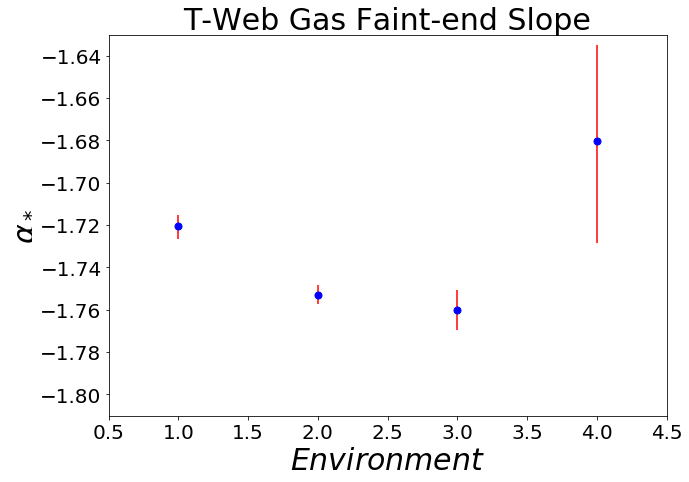

In [62]:
graph(alph,dalph,0.05,r"$\alpha_*$","T-Web Gas Faint-end Slope","TWeb_slope_gas")

# NEAREST NEIGHBOR STELLAR MF

number of haloes before: 191443
number of haloes after: 191443
47861 47861 47861 47861 191444


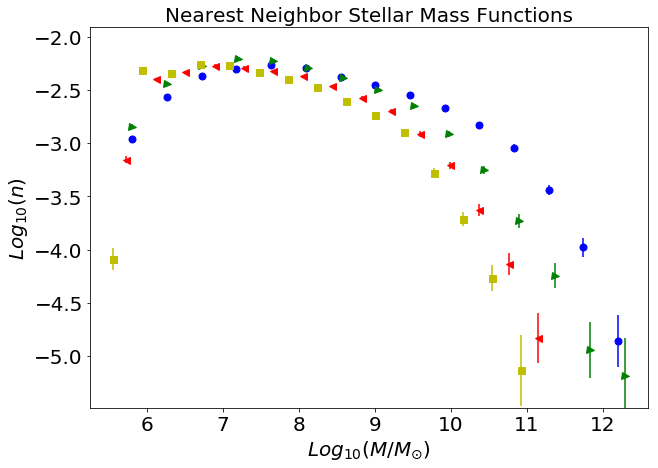

In [63]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,2,0)
#histo(15)
a = SchtrGraph2(15,"quartilesSellar","Nearest Neighbor Stellar Mass Functions",False)

# TWEB STELLAR MF

number of haloes before: 191443
number of haloes after: 191443
24051 96744 61871 8777 191443


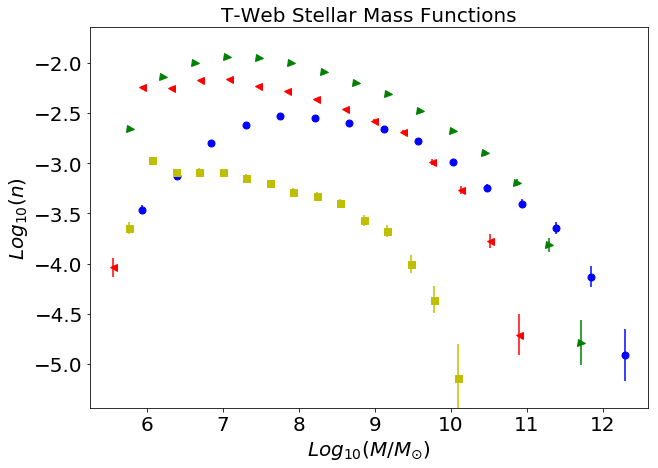

In [64]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,2,10**(0))
a = SchtrGraph2(15,"T-Web_Stellar","T-Web Stellar Mass Functions",False)

# NEAREST NEIGHBOR BH MF

number of haloes before: 191443
number of haloes after: 31510
7878 7877 7878 7878 31511


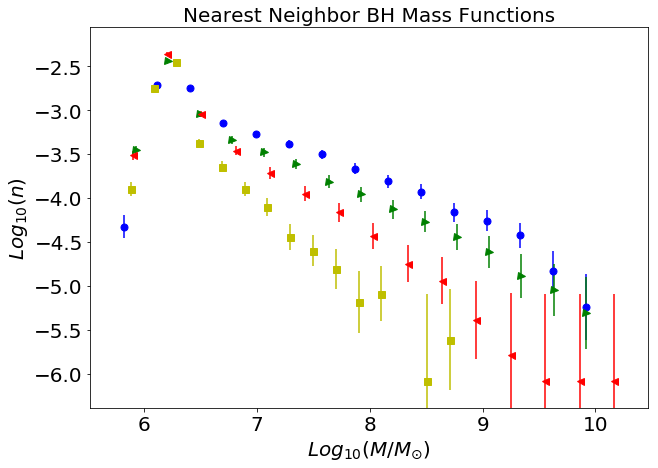

In [65]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,3,0)
#histo(15)
a = SchtrGraph2(15,"quartilesBH","Nearest Neighbor BH Mass Functions",False)

# TWEB BH MF

number of haloes before: 191443
number of haloes after: 31510
5906 17141 7821 642 31510


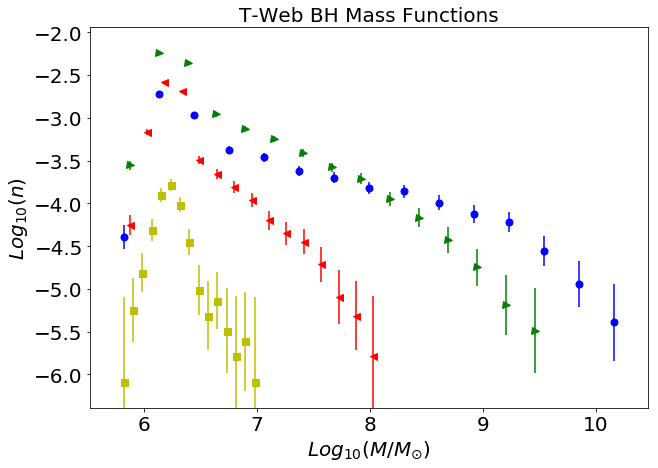

In [66]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,3,10**(0))
a = SchtrGraph2(15,"T-Web_BH","T-Web BH Mass Functions",False)